# Algorithm schematic

This figure shows a network adapting to two statistical contexts.

In [1]:
import frame_whitening as fw
import frame_whitening.plot as fwplt
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

os.chdir(os.path.expanduser("~/frame_whitening"))
print(os.getcwd())

/mnt/home/lduong/frame_whitening


## Define simulation

In [2]:
def simulate(
    cholesky_list, W, batch_size=64, n_batch=1024, lr_g=5e-3, g0=None, seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # initialize random set of gains g
    n, k = W.shape
    if g0 is not None:
        g = g0
    else:
        g = fw.compute_g_opt(np.eye(n), W)  # initialize Parseval frame

    g_all = []
    # run simulation with minibatches
    responses = []
    for Lxx in cholesky_list:
        for _ in range(n_batch):
            x = fw.sample_x(Lxx, batch_size)  # draw a sample of x

            # steady-state of y
            y = np.linalg.inv(W @ np.diag(g) @ W.T) @ x

            # compute z and descend gradient of L(g,y) wrt g
            z = W.T @ y
            # dg = 1/batch_size * np.diag(z @ z.T) - np.diag(W @ W.T)
            dg = np.mean(z**2, -1) - 1.0  # more efficient, local gradient
            g = g + lr_g * dg  # gradient descent

            # Cyy = np.cov(y)
            responses.append((x.mean(-1), y.mean(-1), z.mean(-1)))
            g_all.append(g)
    g_all = np.stack(g_all, 0)
    return g, g_all, responses

## Run simulation

In [3]:
np.random.seed(420)
num_switches = 2
n, k = 2, 3
batch_size = 1
n_batch = 750
lr_g = 3e-3

V, _ = np.linalg.qr(np.random.randn(n, n))
Cxx0 = V @ np.diag([3, 1]) @ V.T * 0.1
V, _ = np.linalg.qr(np.random.randn(n, n))
Cxx1 = V @ np.diag([3, 1]) @ V.T * 0.5
cholesky_list = [np.linalg.cholesky(C) for C in (Cxx0, Cxx1)]
W = fw.get_mercedes_frame()

# g0 = np.random.rand(k) * 1
g0 = np.array([0.01, 1.2, 0.25])
g, g_all, responses = simulate(cholesky_list, W, batch_size, n_batch, lr_g, g0=g0)

## Plots

### Plot the main part of the figure

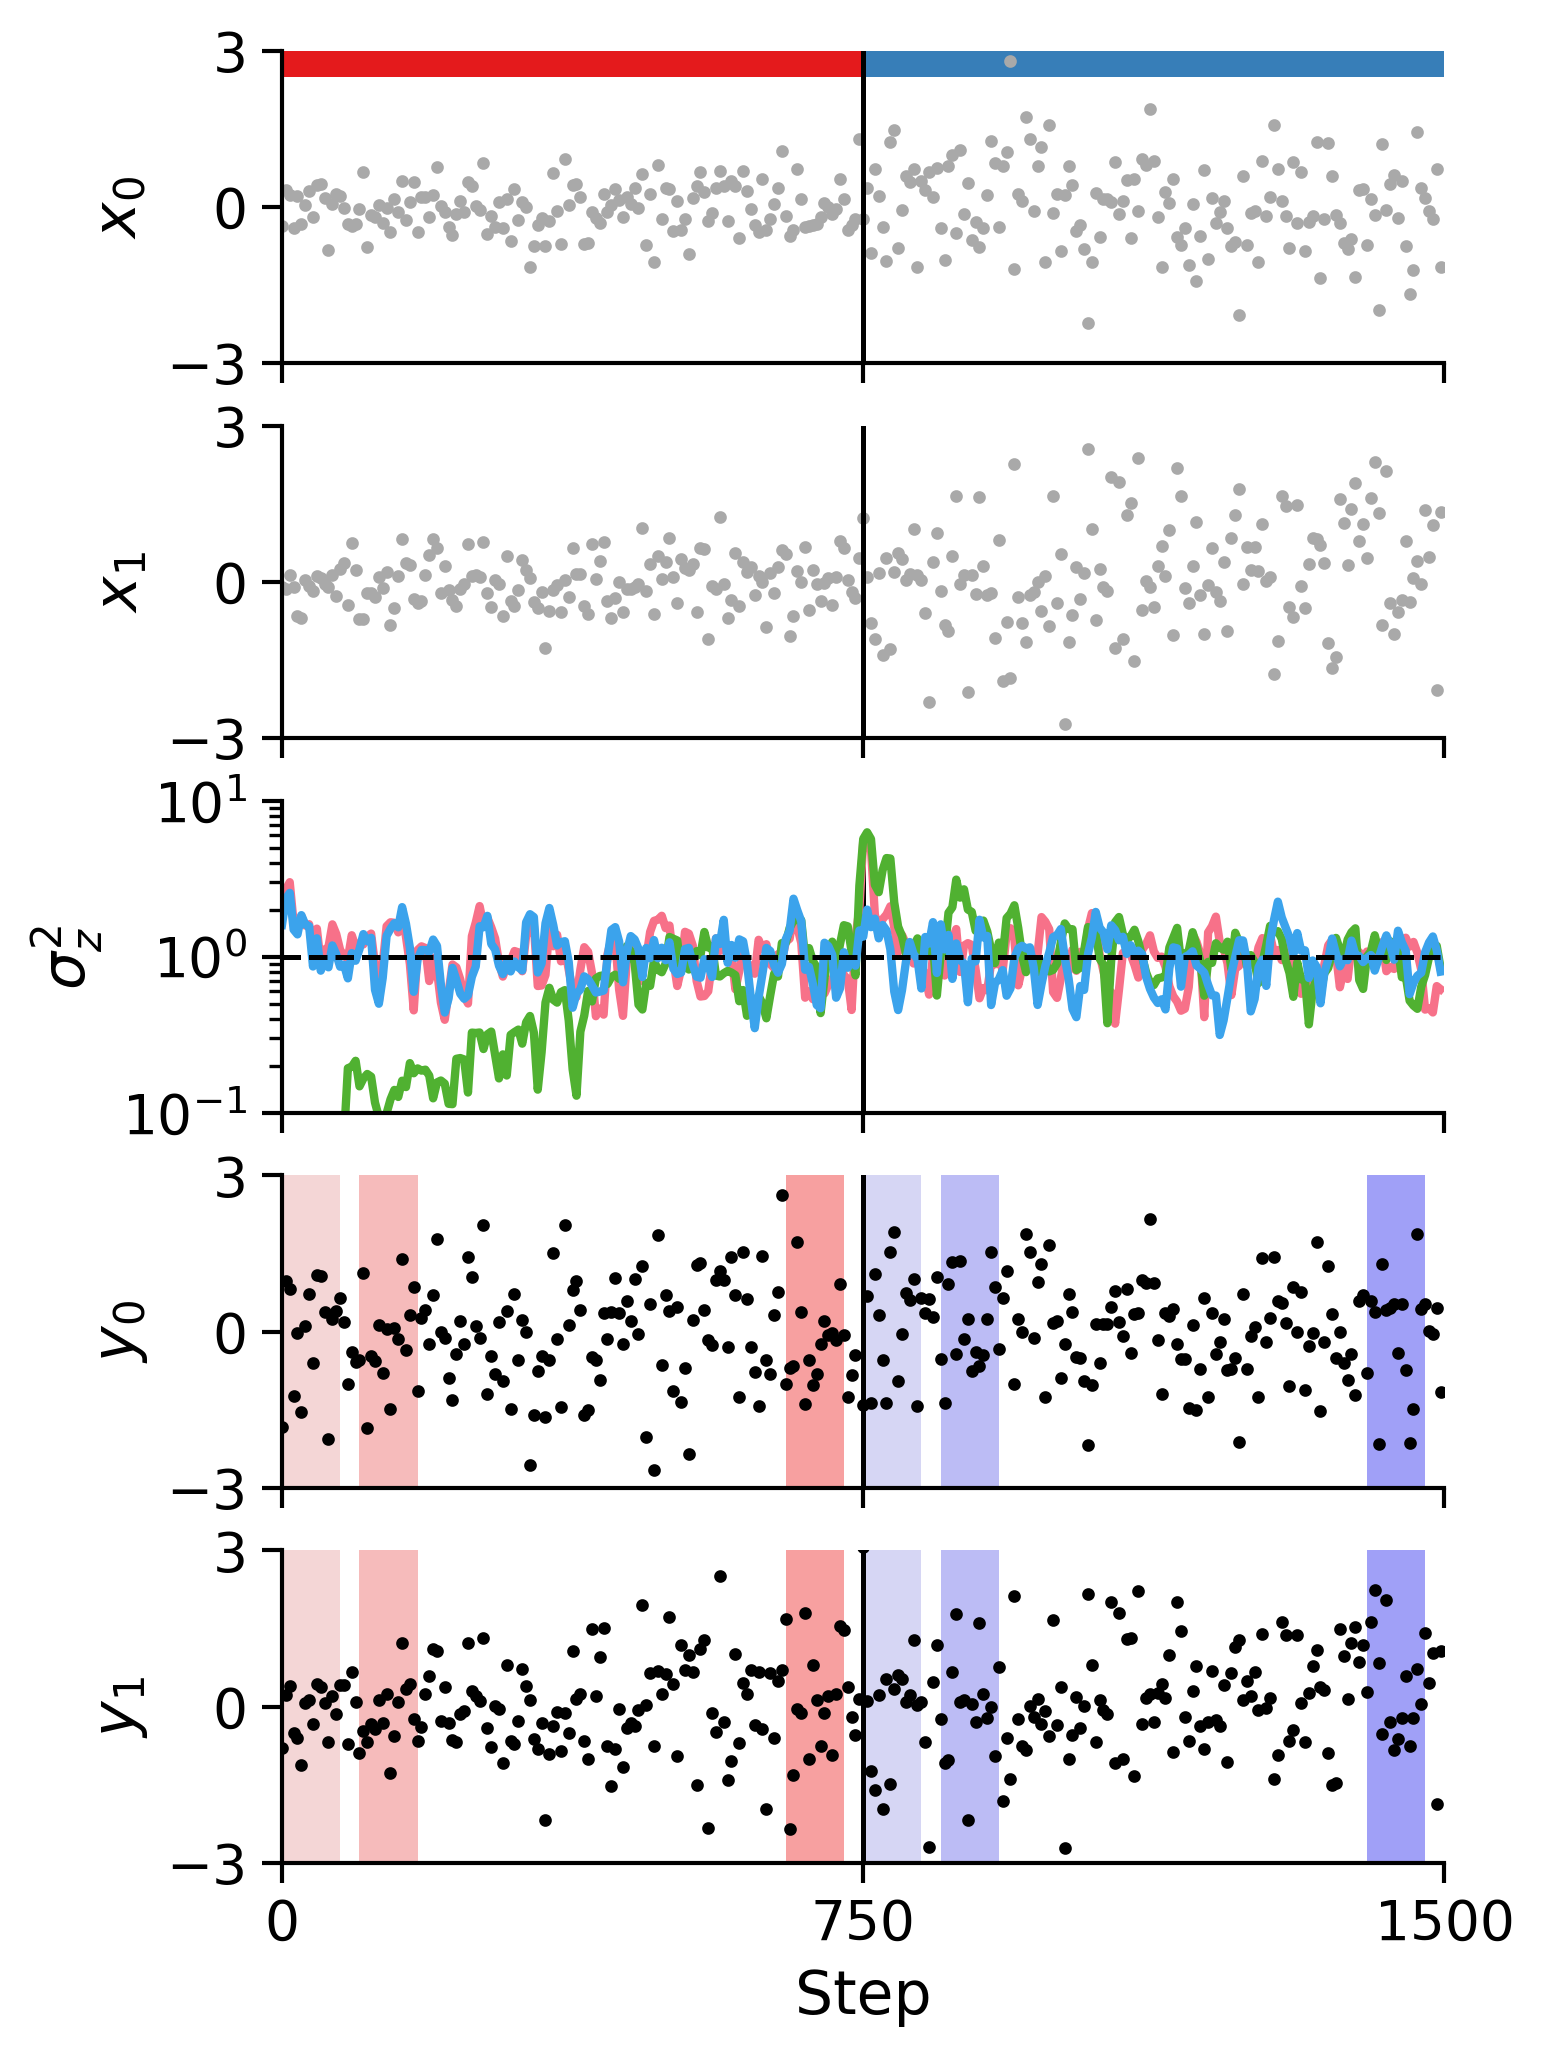

In [6]:
X = np.squeeze(np.array([x for x, _, _ in responses]))
Y = np.squeeze(np.array([y for _, y, _ in responses]))
Z = np.squeeze(np.array([z for _, _, z in responses]))

def moving_average(x, w):
    y = np.zeros_like(x)
    k = y.shape[-1]
    for i in range(k):
        y[:, i] = np.convolve(x[:, i], np.ones(w), "same") / w

    return y

t_skip = 5
X0 = X[::t_skip, :]
Y0 = Y[::t_skip, :]
Y0 = Y[::t_skip, :]

sz2 = Z**2
sz2 = moving_average(sz2, 15)
sz2 = sz2[::t_skip, :]
T = len(X)

cols = sns.color_palette("husl", 3)
ctx_cols = sns.color_palette("Set1", 2)  # context
slice_cols0 = sns.color_palette("light:red", 10)[1:4]
slice_cols1 = sns.color_palette("light:blue", 10)[1:4]

slice_cols = np.concatenate((slice_cols0, slice_cols1))

with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(5, 1, figsize=(5, 8), sharex="all", dpi=300)
    size = 5
    time = np.arange(0, T, t_skip)

    for i in range(5):
        ax[i].vlines(n_batch, -5, 5, linestyle="-", color="k")

    # contexts
    rectangle0 = plt.Rectangle((0, 2.5), n_batch, 1, fc=ctx_cols[0], ec="none")
    rectangle1 = plt.Rectangle((n_batch, 2.5), n_batch, 1, fc=ctx_cols[1], ec="none")
    ax[0].add_patch(rectangle0)
    ax[0].add_patch(rectangle1)

    # x inputs
    ax[0].scatter(time, X0[:, 0], s=size, c="darkgrey")
    ax[1].scatter(time, X0[:, 1], s=size, c="darkgrey")

    # z variance
    [ax[2].plot(time, sz2[:, i], color=cols[i], linewidth=2) for i in range(k)]
    ax[2].hlines(1, 0, time[-1], linestyle="--", color="k")

    # time slices
    for i, tt in enumerate((0, 100, 650, 750, 850, 1400)):
        for j in (-2, -1):
            rect = plt.Rectangle((tt, -5), 75, 10, fc=slice_cols[i], ec="none")
            ax[j].add_patch(rect)

    # y outputs
    ax[-2].scatter(time, Y0[:, 0], s=size, color="k")
    ax[-1].scatter(time, Y0[:, 1], s=size, color="k")

    ylim_x = (-3, 3)
    ylim_y = (-3, 3)
    yticks_x = (-3, 0, 3)
    yticks_y = (-3, 0, 3)
    ax[0].set(ylabel=r"$x_0$", ylim=ylim_x, yticks=yticks_x, xlim=(0, T))
    ax[1].set(ylabel=r"$x_1$", ylim=ylim_x, yticks=yticks_x)
    ax[2].set(ylabel=r"$\sigma^2_z$", ylim=(1e-1, 10), yscale="log")
    ax[-2].set(ylabel=r"$y_0$", ylim=ylim_y, yticks=yticks_y)
    ax[-1].set(ylabel=r"$y_1$", xlabel="Step", ylim=ylim_y, yticks=yticks_y)
    ax[-1].set(xticks=(0, 750, 1500))

    sns.despine()

### Plot the insets

Background colours of these plots match those of the main figure.

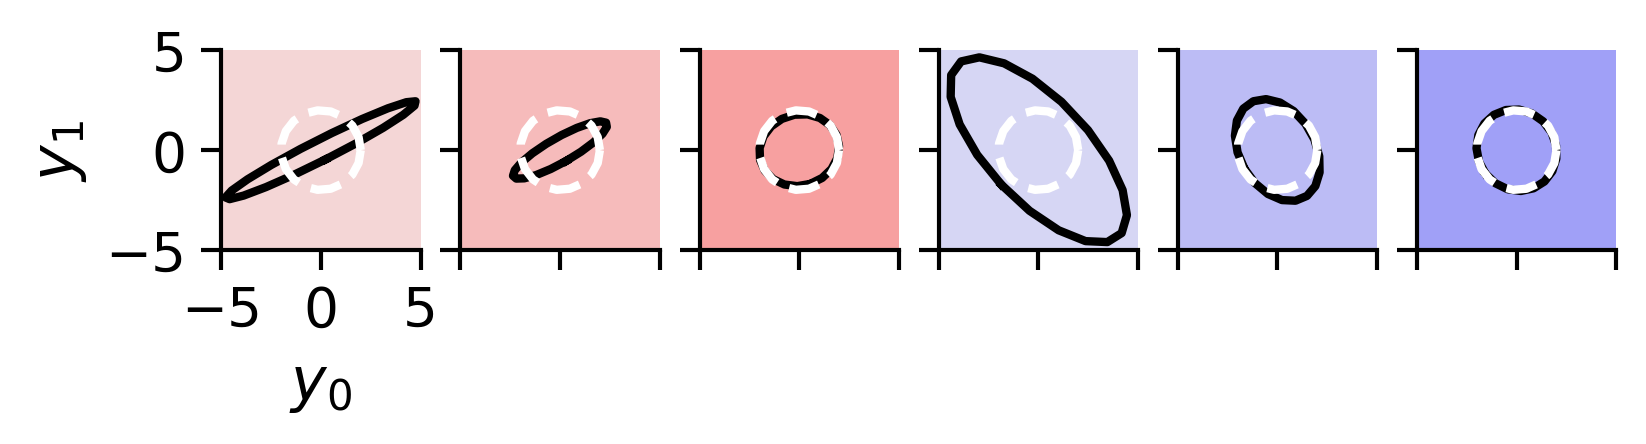

In [7]:
def get_Cyy(Cxx, W, g):
    M = np.linalg.inv(W @ np.diag(g) @ W.T)
    Cyy = M @ Cxx @ M
    return Cyy


In = np.eye(2)
with sns.plotting_context("paper", font_scale=1.5):
    fig_dims = (1, 6)
    fig, ax = plt.subplots(*fig_dims, figsize=(6, 5), dpi=300, squeeze=False)

    I_kwargs = {"linestyle": "--", "linewidth": 2, "color": "w"}
    Cyy_kwargs = {"linewidth": 2, "color": "k"}
    t_slice = (0, 100, n_batch, n_batch + 1, n_batch + 100, -1)
    for i in range(len(t_slice)):
        idx = np.unravel_index(i, fig_dims)
        ctx = i > 2
        Lxx = cholesky_list[ctx]

        t0 = t_slice[i]
        Cxx = Lxx @ Lxx.T
        Cyy = get_Cyy(Cxx, W, g_all[t0])

        fwplt.plot_ellipse(Cyy, ax=ax[idx], **Cyy_kwargs)
        fwplt.plot_ellipse(In, ax=ax[idx], **I_kwargs)
        lim_sq = 5
        idx = np.unravel_index(i, fig_dims)
        ax[idx].axis("square")
        ax[idx].set(xlim=(-lim_sq, lim_sq), ylim=(-lim_sq, lim_sq))
        rect = plt.Rectangle((-5, -5), 10, 10, fc=slice_cols[i], ec="none")
        ax[idx].add_patch(rect)
        if i > 0:
            ax[idx].set(xticklabels=[], yticklabels=[])
    ax[0, 0].set(xlabel=r"$y_0$", ylabel=r"$y_1$", xticks=(-5, 0, 5), yticks=(-5, 0, 5))
    sns.despine()